--- Memvisualisasikan Dampak Preprocessing pada: Data_Temperatur.xlsx ---


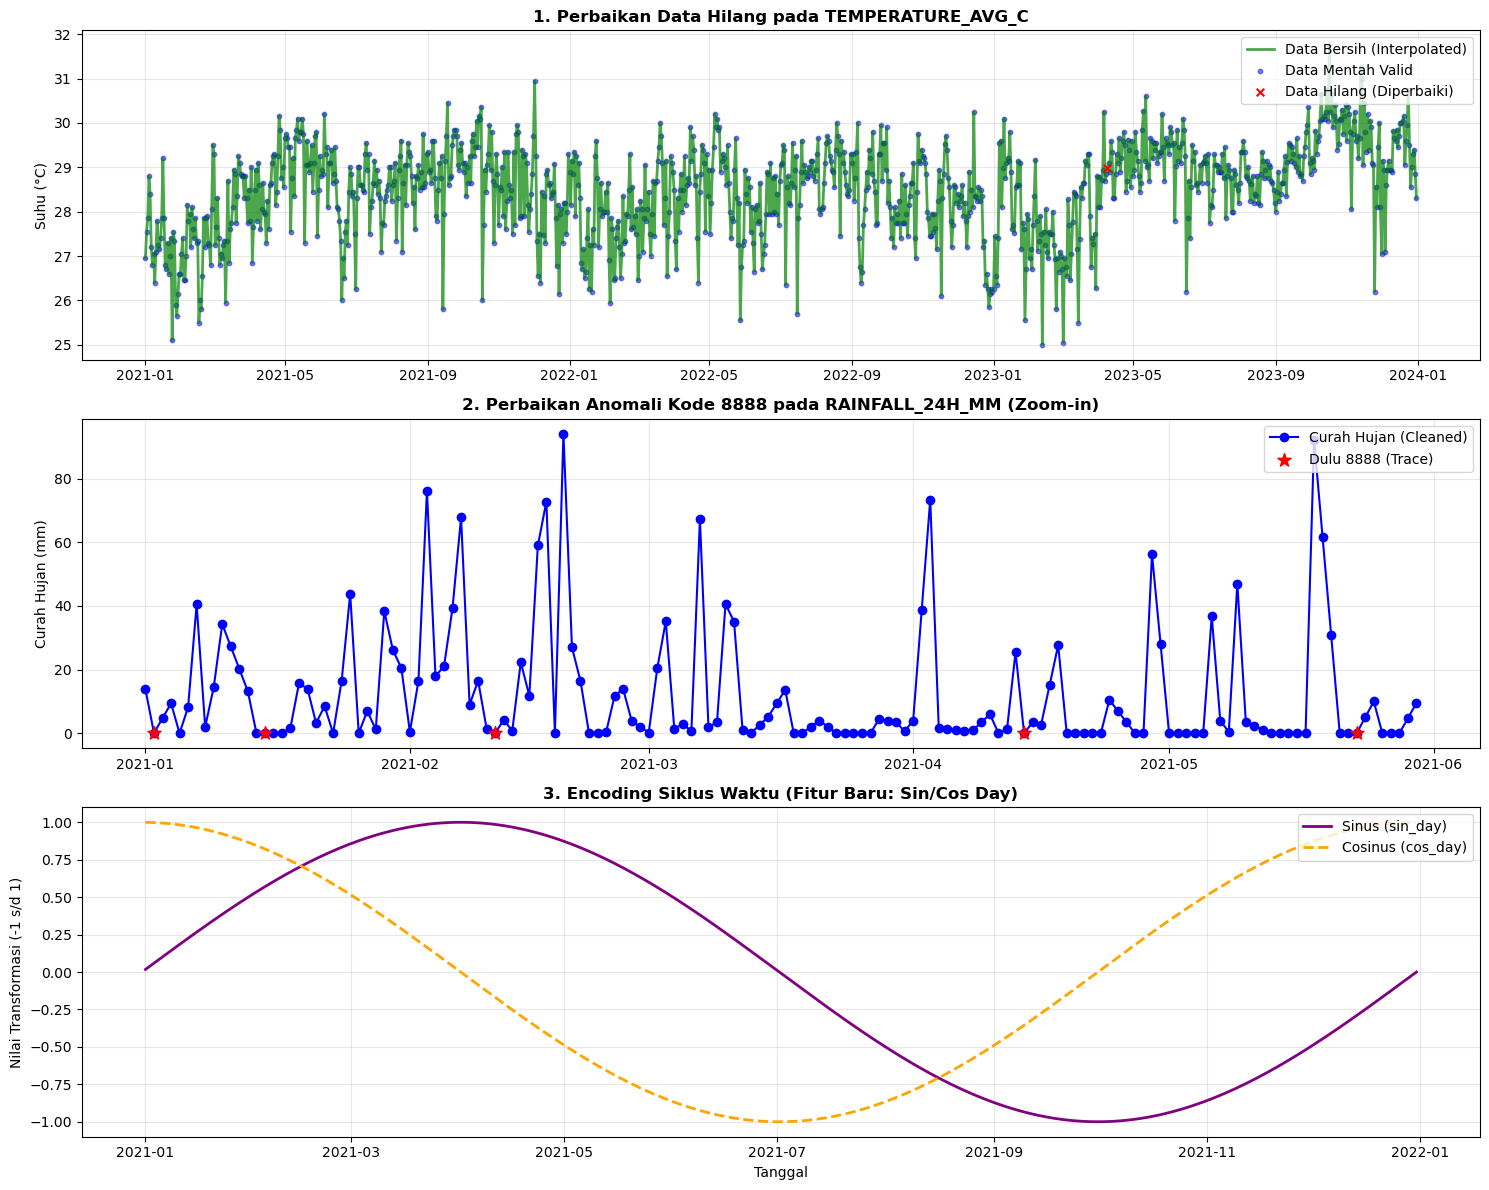

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_preprocessing_impact(filepath):
    print(f"--- Memvisualisasikan Dampak Preprocessing pada: {filepath} ---")
    
    # 1. LOAD DATA MENTAH (RAW)
    try:
        if filepath.endswith('.csv'):
            df_raw = pd.read_csv(filepath)
        else:
            df_raw = pd.read_excel(filepath)
    except Exception as e:
        print(f"Error: {e}")
        return

    # Bersihkan nama kolom
    df_raw.columns = df_raw.columns.str.strip()
    
    # Cari kolom tanggal
    date_col = [c for c in df_raw.columns if 'DATE' in c or 'TIMESTAMP' in c][0]
    df_raw[date_col] = pd.to_datetime(df_raw[date_col])
    df_raw = df_raw.sort_values(date_col)
    
    # Ambil kolom target
    target_col = 'TEMPERATURE_AVG_C'
    rain_col = 'RAINFALL_24H_MM'

    # Buat salinan untuk diproses (CLEAN)
    df_clean = df_raw.copy()

    # --- PROSES CLEANING & ENGINEERING ---
    
    # 1. Handling 9999 & 8888
    missing_mask = (df_clean[target_col] == 9999) | (df_clean[target_col].isna())
    
    df_clean = df_clean.replace(9999, np.nan)
    if rain_col in df_clean.columns:
        df_clean[rain_col] = df_clean[rain_col].replace(8888, 0.05)
    
    # 2. Interpolasi
    df_clean[target_col] = df_clean[target_col].interpolate(method='linear')
    df_clean[rain_col] = df_clean[rain_col].interpolate(method='linear')

    # 3. Encoding Siklus Waktu (BAGIAN YANG DITAMBAHKAN)
    # Mengubah hari ke-n dalam setahun menjadi sin/cos untuk menangkap pola musim
    df_clean['day_of_year'] = df_clean[date_col].dt.dayofyear
    df_clean['sin_day'] = np.sin(2 * np.pi * df_clean['day_of_year'] / 365.0)
    df_clean['cos_day'] = np.cos(2 * np.pi * df_clean['day_of_year'] / 365.0)

    # --- VISUALISASI ---
    
    plt.figure(figsize=(15, 12)) # Diperbesar untuk 3 plot
    
    # SUBPLOT 1: Missing Values
    plt.subplot(3, 1, 1)
    plt.plot(df_clean[date_col], df_clean[target_col], 
             color='green', label='Data Bersih (Interpolated)', linewidth=2, alpha=0.7)
    valid_raw = df_raw[df_raw[target_col] != 9999]
    plt.scatter(valid_raw[date_col], valid_raw[target_col], 
                color='blue', s=10, label='Data Mentah Valid', alpha=0.5)
    imputed_data = df_clean[missing_mask]
    if not imputed_data.empty:
        plt.scatter(imputed_data[date_col], imputed_data[target_col], 
                    color='red', s=30, marker='x', label='Data Hilang (Diperbaiki)', zorder=5)
    plt.title(f'1. Perbaikan Data Hilang pada {target_col}', fontsize=12, fontweight='bold')
    plt.ylabel('Suhu (°C)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    # SUBPLOT 2: Anomaly Rainfall
    plt.subplot(3, 1, 2)
    if rain_col in df_raw.columns:
        subset_n = 150 # Zoom 150 hari pertama
        dates_sub = df_clean[date_col].iloc[:subset_n]
        rain_clean_sub = df_clean[rain_col].iloc[:subset_n]
        rain_raw_sub = df_raw[rain_col].iloc[:subset_n]
        
        plt.plot(dates_sub, rain_clean_sub, color='blue', label='Curah Hujan (Cleaned)', marker='o')
        anomaly_indices = rain_raw_sub == 8888
        if anomaly_indices.any():
            plt.scatter(dates_sub[anomaly_indices], rain_clean_sub[anomaly_indices], 
                        color='red', s=100, marker='*', label='Dulu 8888 (Trace)', zorder=10)
        plt.title(f'2. Perbaikan Anomali Kode 8888 pada {rain_col} (Zoom-in)', fontsize=12, fontweight='bold')
        plt.ylabel('Curah Hujan (mm)')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)

    # SUBPLOT 3: Time Cycle Encoding (Baru)
    plt.subplot(3, 1, 3)
    # Plot 1 tahun pertama saja agar gelombangnya terlihat jelas
    subset_year = df_clean[df_clean[date_col] < df_clean[date_col].min() + pd.Timedelta(days=365)]
    
    plt.plot(subset_year[date_col], subset_year['sin_day'], label='Sinus (sin_day)', color='purple', linewidth=2)
    plt.plot(subset_year[date_col], subset_year['cos_day'], label='Cosinus (cos_day)', color='orange', linewidth=2, linestyle='--')
    
    plt.title('3. Encoding Siklus Waktu (Fitur Baru: Sin/Cos Day)', fontsize=12, fontweight='bold')
    plt.ylabel('Nilai Transformasi (-1 s/d 1)')
    plt.xlabel('Tanggal')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    file_path = 'Data_Temperatur.xlsx'
    visualize_preprocessing_impact(file_path)